# Fourier Neural Operator: Learning Solution Operators in Spectral Space

**Learning Objectives:**
- Understand the connection between CNNs and kernel operators
- Master Fourier Transform fundamentals for neural operators
- Learn the FNO architecture: spectral convolution layers
- Implement FNO for 1D Burgers equation
- Apply FNO to 2D Darcy Flow problem
- Explore mesh independence and super-resolution capabilities

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/05-fno/fno-exercise.ipynb)

**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/05-fno/fno.ipynb)

**Paper:** [Fourier Neural Operator for Parametric PDEs](https://arxiv.org/abs/2010.08895)

---

In [ ]:
# Google Colab Setup (run this cell first in Colab)
# This cell downloads data from Hugging Face - no login required!

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install required packages
    !pip install -q huggingface_hub h5py scipy
    
    from huggingface_hub import hf_hub_download
    import os
    import shutil
    
    # Create directories
    !mkdir -p fourier_neural_operator/Darcy_241
    
    print("Downloading datasets from Hugging Face...")
    
    # Download Burgers data
    burgers_file = hf_hub_download(
        repo_id="kks32/sciml-dataset",
        filename="fno/burgers_data_R10.mat",
        repo_type="dataset"
    )
    shutil.copy(burgers_file, "fourier_neural_operator/burgers_data_R10.mat")
    
    # Download Darcy training data
    darcy_train = hf_hub_download(
        repo_id="kks32/sciml-dataset",
        filename="fno/Darcy_241/piececonst_r241_N1024_smooth1.mat",
        repo_type="dataset"
    )
    shutil.copy(darcy_train, "fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth1.mat")
    
    # Download Darcy test data
    darcy_test = hf_hub_download(
        repo_id="kks32/sciml-dataset",
        filename="fno/Darcy_241/piececonst_r241_N1024_smooth2.mat",
        repo_type="dataset"
    )
    shutil.copy(darcy_test, "fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth2.mat")
    
    # Download utilities
    !wget -q https://raw.githubusercontent.com/kks32-courses/sciml/main/docs/05-fno/fourier_neural_operator/utilities3.py -O fourier_neural_operator/utilities3.py
    
    print("\n✅ Setup complete! Data downloaded from Hugging Face.")
    print(f"  Burgers: {os.path.getsize('fourier_neural_operator/burgers_data_R10.mat') / 1024**2:.1f} MB")
    print(f"  Darcy train: {os.path.getsize('fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth1.mat') / 1024**2:.1f} MB")
    print(f"  Darcy test: {os.path.getsize('fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth2.mat') / 1024**2:.1f} MB")
else:
    print("Not in Colab - skipping data download")

## The Central Challenge

We've seen how DeepONet learns operators by decomposing them into branch-trunk architectures.

**But there's a deeper question:** What if physics itself suggests the right representation?

For 50+ years, **spectral methods** based on Fourier transforms have dominated computational physics. They work because:
- Many PDEs simplify in Fourier space (convolution → multiplication)
- Derivatives become algebraic: $\mathcal{F}(\frac{\partial u}{\partial x}) = ik\hat{u}(k)$
- Global information propagates naturally

**The FNO insight:** Learn operators *in Fourier space* rather than physical space.

$$\text{Input} \xrightarrow{\text{FFT}} \text{Fourier Space} \xrightarrow{\text{Learn}} \text{Fourier Space} \xrightarrow{\text{IFFT}} \text{Output}$$

In [3]:
!pip install -q h5py scipy

In [9]:
# Install required packages
!pip install -q h5py scipy

# Download utilities
!wget -q https://raw.githubusercontent.com/neuraloperator/neuraloperator/main/neuralop/datasets/data_utils.py -O utilities3.py

# Create directory structure
!mkdir -p fourier_neural_operator/Darcy_241
!mkdir -p figs

# Download Burgers equation data
!wget -q "https://drive.google.com/uc?export=download&id=1r2PidLEU0STjy02ldB8vXGu5Qp1W_r2w" -O fourier_neural_operator/burgers_data_R10.mat

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os

# Add fourier_neural_operator to path for utilities
sys.path.insert(0, os.path.abspath('fourier_neural_operator'))
from utilities3 import MatReader, UnitGaussianNormalizer, LpLoss, count_params

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU")
        return device
    elif torch.backends.mps.is_available():
        # MPS has issues with complex FFT operations, causing slow CPU↔MPS transfers
        # For FNO, CPU is often faster than MPS due to FFT overhead
        print("Apple Silicon detected, but using CPU for better FFT performance")
        print("(MPS has overhead with complex FFT operations)")
        return torch.device("cpu")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()
print(f"Device: {device}")
print("Training will be optimized for this device")

Using CUDA GPU
Device: cuda
Training will be optimized for this device


## From CNNs to Kernel Operators

### Convolutional Neural Networks

CNNs apply **local** kernels to extract features:

$$(f * g)(x) = \int_{\text{local}} f(x') g(x - x') dx'$$

![CNN Architecture](figs/cnn.png)

**Key properties:**
- Translation invariant
- Local receptive field
- Successful for images

![CNN Convolution Operation](figs/cnn-pooling.png)

### Kernel Operators: The General Form

A kernel operator maps functions to functions:

$$\mathcal{K}(v)(x) = \int_{\Omega} \kappa(x, x') v(x') dx'$$

where $\kappa(x, x')$ is a **learned kernel**.

**Types of kernels:**
1. **Standard convolution:** $\kappa(x, x') = k(x - x')$ (local, translation-invariant)
2. **Graph operators:** $\kappa$ defined on graph edges
3. **Fourier operators:** $\kappa$ learned in spectral space (global, efficient)

### Why Fourier?

**Convolution theorem:** Convolution in physical space = multiplication in Fourier space

$$\mathcal{F}(f * g) = \mathcal{F}(f) \cdot \mathcal{F}(g)$$

This means we can:
1. Transform to Fourier space (FFT)
2. Learn simple multiplication weights
3. Transform back (IFFT)

**Computational advantage:** FFT is $O(N \log N)$, far cheaper than dense convolution $O(N^2)$.

## Fourier Transform: The Foundation

### Mathematical Definition

The **Fourier Transform** decomposes a function into sinusoidal components:

$$\hat{u}(k) = \mathcal{F}(u)(k) = \int_{-\infty}^{\infty} u(x) e^{-ikx} dx$$

**Inverse Fourier Transform:**

$$u(x) = \mathcal{F}^{-1}(\hat{u})(x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \hat{u}(k) e^{ikx} dk$$

**Key insight:** Any function can be written as:

$$u(x) = \sum_{k} \hat{u}_k e^{ikx}$$

where $\hat{u}_k$ are **Fourier coefficients** (complex weights) and $e^{ikx}$ are basis functions.

### Properties

1. **Derivatives become multiplication:** $\mathcal{F}(\frac{\partial u}{\partial x}) = ik\hat{u}(k)$
2. **Convolution becomes multiplication:** $\mathcal{F}(u * v) = \mathcal{F}(u) \cdot \mathcal{F}(v)$
3. **Parseval's theorem:** $\int |u(x)|^2 dx = \int |\hat{u}(k)|^2 dk$

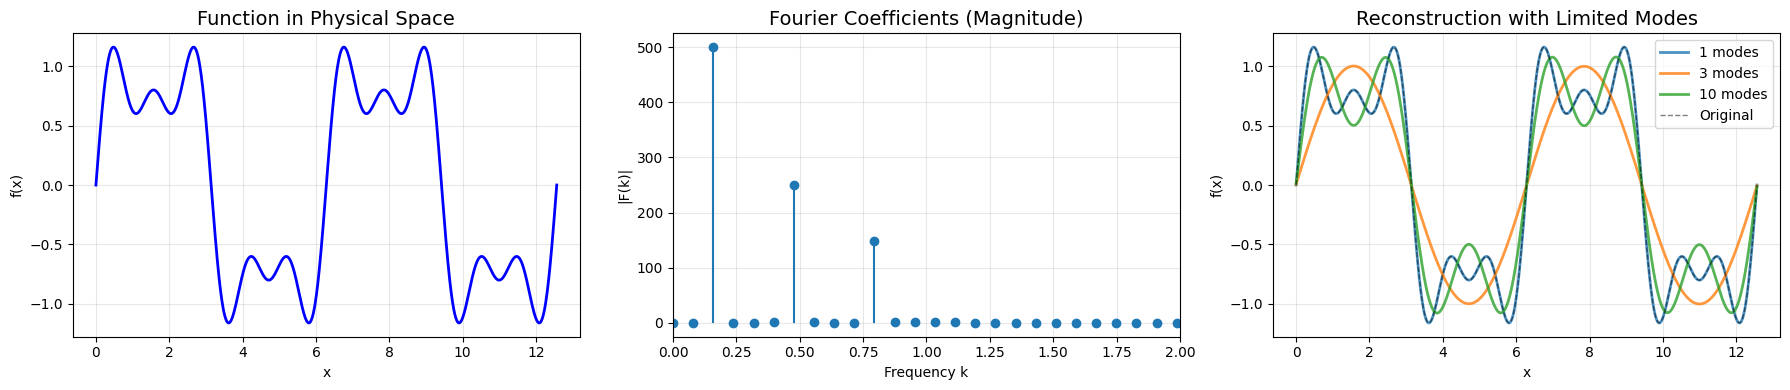

Key observation: Most energy concentrated in low frequencies
FNO exploits this by learning weights only for low-frequency modes


In [11]:
# Demonstrate Fourier decomposition
def demonstrate_fourier():
    x = np.linspace(0, 4*np.pi, 1000)

    # Create a composite function
    f = np.sin(x) + 0.5*np.sin(3*x) + 0.3*np.sin(5*x)

    # Compute FFT
    f_fft = np.fft.fft(f)
    freqs = np.fft.fftfreq(len(x), x[1] - x[0])

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Original function
    axes[0].plot(x, f, 'b-', linewidth=2)
    axes[0].set_title('Function in Physical Space', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('f(x)')
    axes[0].grid(True, alpha=0.3)

    # Fourier coefficients (magnitude)
    axes[1].stem(freqs[:len(freqs)//2], np.abs(f_fft[:len(freqs)//2]), basefmt=' ')
    axes[1].set_title('Fourier Coefficients (Magnitude)', fontsize=14)
    axes[1].set_xlabel('Frequency k')
    axes[1].set_ylabel('|F(k)|')
    axes[1].set_xlim([0, 2])
    axes[1].grid(True, alpha=0.3)

    # Reconstruction with limited modes
    for n_modes in [1, 3, 10]:
        f_fft_truncated = f_fft.copy()
        f_fft_truncated[n_modes:-n_modes+1] = 0
        f_reconstructed = np.fft.ifft(f_fft_truncated).real
        axes[2].plot(x, f_reconstructed, linewidth=2, label=f'{n_modes} modes', alpha=0.8)

    axes[2].plot(x, f, 'k--', linewidth=1, label='Original', alpha=0.5)
    axes[2].set_title('Reconstruction with Limited Modes', fontsize=14)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('f(x)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Key observation: Most energy concentrated in low frequencies")
    print("FNO exploits this by learning weights only for low-frequency modes")

demonstrate_fourier()

## Fourier Neural Operator Architecture

### The Core Idea

Instead of learning in physical space, **learn in Fourier space**:

$$v_{t+1}(x) = \sigma\left(W v_t(x) + \mathcal{K}(v_t)(x)\right)$$

where the kernel operator $\mathcal{K}$ is parameterized in Fourier space:

$$\mathcal{K}(v)(x) = \mathcal{F}^{-1}\left(R_\phi \cdot \mathcal{F}(v)\right)(x)$$

Here, $R_\phi$ are **learnable weights** in Fourier space.

### Complete FNO Architecture

![Fourier Neural Operator Architecture](figs/fourier_architecture.png)

The architecture consists of:

```
Input u(x)  [batch, n_points, d_in]
    ↓
Lifting: P(u) → v₀  [batch, n_points, width]
    ↓
Fourier Layer 1: v₁ = σ(W₀v₀ + K₀(v₀))
Fourier Layer 2: v₂ = σ(W₁v₁ + K₁(v₁))
Fourier Layer 3: v₃ = σ(W₂v₂ + K₂(v₂))
Fourier Layer 4: v₄ = σ(W₃v₃ + K₃(v₃))
    ↓
Projection: Q(v₄) → output  [batch, n_points, d_out]
```

### Spectral Convolution Layer

Each Fourier layer performs:

1. **FFT:** $\hat{v} = \mathcal{F}(v)$
2. **Linear transform (truncated):** $\hat{v}_{\text{out}}[k] = R_\phi[k] \cdot \hat{v}[k]$ for $k \leq k_{\text{max}}$
3. **IFFT:** $v_{\text{out}} = \mathcal{F}^{-1}(\hat{v}_{\text{out}})$

**Key design choice:** Only keep low-frequency modes ($k_{\text{max}} \approx 12-16$), discard high frequencies.

## 1D Example: Burgers Equation

### Problem Formulation

The 1D viscous Burgers equation:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 2\pi], t \in [0, T]$$

with periodic boundary conditions and initial condition $u(x, 0) = u_0(x)$.

**Operator learning task:** Learn the mapping

$$\mathcal{G}: u_0(x) \mapsto u(x, T)$$

from initial condition to solution at time $T$.

**Dataset:** 1024 training samples from varied initial conditions, solved using spectral methods.

Loading Burgers equation dataset...
Data shape: torch.Size([2048, 8192])
Number of samples: 2048
Grid resolution: 8192
Subsampled resolution: 2048


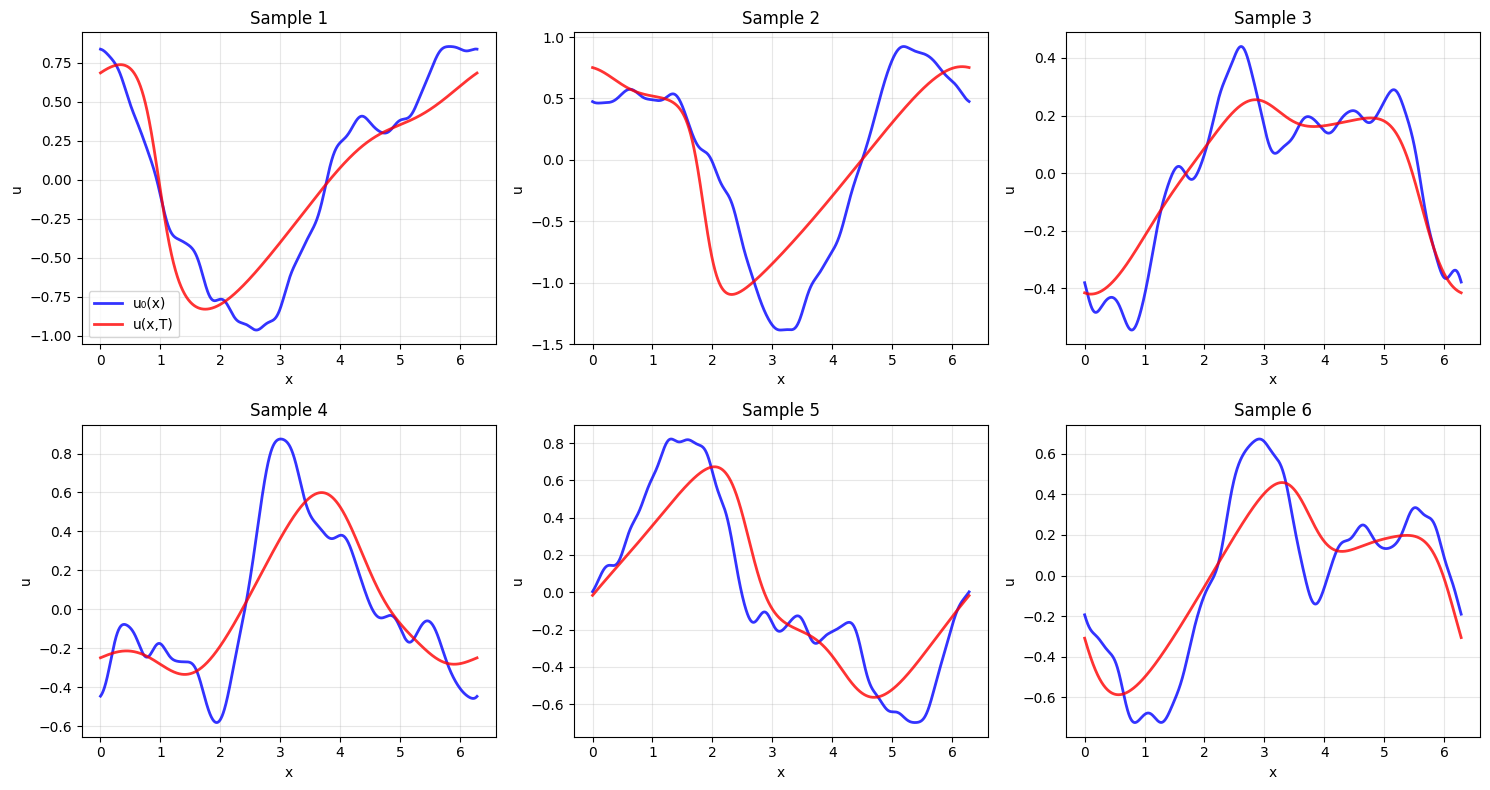

In [15]:
# Load Burgers equation data
print("Loading Burgers equation dataset...")

dataloader = MatReader('burgers_data_R10.mat')
x_data = dataloader.read_field('a')  # Initial conditions
y_data = dataloader.read_field('u')  # Solutions at T=1

print(f"Data shape: {x_data.shape}")
print(f"Number of samples: {x_data.shape[0]}")
print(f"Grid resolution: {x_data.shape[1]}")

# Subsample for computational efficiency
sub = 4
x_data = x_data[:, ::sub]
y_data = y_data[:, ::sub]

print(f"Subsampled resolution: {x_data.shape[1]}")

# Visualize samples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
x_grid = np.linspace(0, 2*np.pi, x_data.shape[1])

for i in range(6):
    ax = axes[i//3, i%3]
    ax.plot(x_grid, x_data[i], 'b-', linewidth=2, label='u₀(x)', alpha=0.8)
    ax.plot(x_grid, y_data[i], 'r-', linewidth=2, label='u(x,T)', alpha=0.8)
    ax.set_title(f'Sample {i+1}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### 1D Fourier Neural Operator Implementation

In [16]:
class SpectralConv1d(nn.Module):
    """1D Fourier layer: FFT → Linear transform → IFFT"""

    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # Number of Fourier modes


        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat)
        )

    def forward(self, x):
        # x: [batch, in_channels, n_points]

        # FFT
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,
                            device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = torch.einsum(
            "bix,iox->box", x_ft[:, :, :self.modes], self.weights
        )

        # IFFT
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FNO1d(nn.Module):
    """1D Fourier Neural Operator"""

    def __init__(self, modes, width, n_layers=4):
        super().__init__()
        self.modes = modes
        self.width = width
        self.n_layers = n_layers

        # Lifting: embed input to high-dimensional space
        self.fc0 = nn.Linear(2, width)  # input: (u₀(x), x)

        # Fourier layers
        self.fourier_layers = nn.ModuleList([
            SpectralConv1d(width, width, modes) for _ in range(n_layers)
        ])

        # Skip connections
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(width, width, 1) for _ in range(n_layers)
        ])

        # Projection: map back to output
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: [batch, n_points, 2]

        # Lift
        x = self.fc0(x)  # [batch, n_points, width]
        x = x.permute(0, 2, 1)  # [batch, width, n_points]

        # Fourier layers with skip connections
        for fourier, conv in zip(self.fourier_layers[:-1], self.conv_layers[:-1]):
            x1 = fourier(x)
            x2 = conv(x)
            x = F.gelu(x1 + x2)

        # Last layer (no activation)
        x1 = self.fourier_layers[-1](x)
        x2 = self.conv_layers[-1](x)
        x = x1 + x2

        # Project
        x = x.permute(0, 2, 1)  # [batch, n_points, width]
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # [batch, n_points, 1]

        return x.squeeze(-1)


# Initialize model
modes = 16
width = 64
model_1d = FNO1d(modes, width).to(device)

print(f"FNO1d Architecture:")
print(f"- Fourier modes: {modes}")
print(f"- Hidden width: {width}")
print(f"- Total parameters: {count_params(model_1d):,}")
print(f"- Device: {device}")

FNO1d Architecture:
- Fourier modes: 16
- Hidden width: 64
- Total parameters: 287,425
- Device: cuda


### Training the 1D FNO

In [17]:
# Prepare data
ntrain = 1000
ntest = 100
batch_size = 20

x_train = x_data[:ntrain]
y_train = y_data[:ntrain]
x_test = x_data[-ntest:]
y_test = y_data[-ntest:]

# Add spatial coordinates
s = x_train.shape[1]
grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float32)

x_train = torch.cat([x_train.reshape(ntrain, s, 1), grid.repeat(ntrain, 1, 1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest, s, 1), grid.repeat(ntest, 1, 1)], dim=2)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=batch_size, shuffle=False
)

print(f"Training samples: {ntrain}")
print(f"Test samples: {ntest}")
print(f"Batch size: {batch_size}")

Training samples: 1000
Test samples: 100
Batch size: 20


In [18]:
# Training configuration
epochs = 200  # Reduced from 500 for faster demonstration
learning_rate = 0.001

optimizer = torch.optim.Adam(model_1d.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate,
    div_factor=1e4, final_div_factor=1e4,
    steps_per_epoch=len(train_loader), epochs=epochs
)

myloss = LpLoss(d=1, p=2, size_average=False)

# Training loop
train_losses = []
test_losses = []

print(f"Training FNO1d for {epochs} epochs...")
pbar = tqdm(range(epochs), desc="Training")

for epoch in pbar:
    model_1d.train()
    train_l2 = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model_1d(x)

        loss = myloss(out.view(x.shape[0], -1), y.view(x.shape[0], -1))
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_l2 += loss.item()

    # Evaluation
    model_1d.eval()
    test_l2 = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model_1d(x)
            test_l2 += myloss(out.view(x.shape[0], -1), y.view(x.shape[0], -1)).item()

    train_l2 /= ntrain
    test_l2 /= ntest

    train_losses.append(train_l2)
    test_losses.append(test_l2)

    if epoch % 20 == 0:
        pbar.set_postfix({'Train L2': f'{train_l2:.6f}', 'Test L2': f'{test_l2:.6f}'})

print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final test loss: {test_losses[-1]:.6f}")

Training FNO1d for 200 epochs...


Training: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s, Train L2=0.001199, Test L2=0.001310]

Final train loss: 0.000737
Final test loss: 0.001043


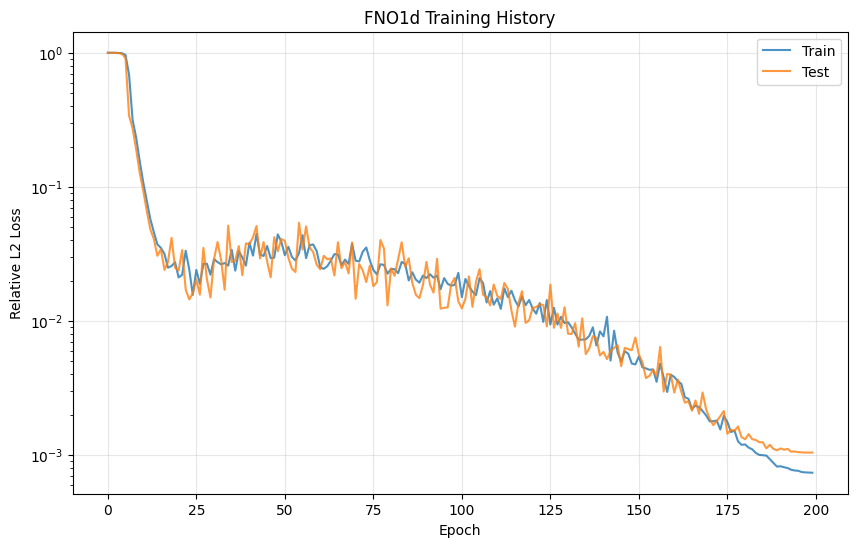

In [19]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train', alpha=0.8)
plt.plot(test_losses, label='Test', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Relative L2 Loss')
plt.title('FNO1d Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

### 1D FNO Results

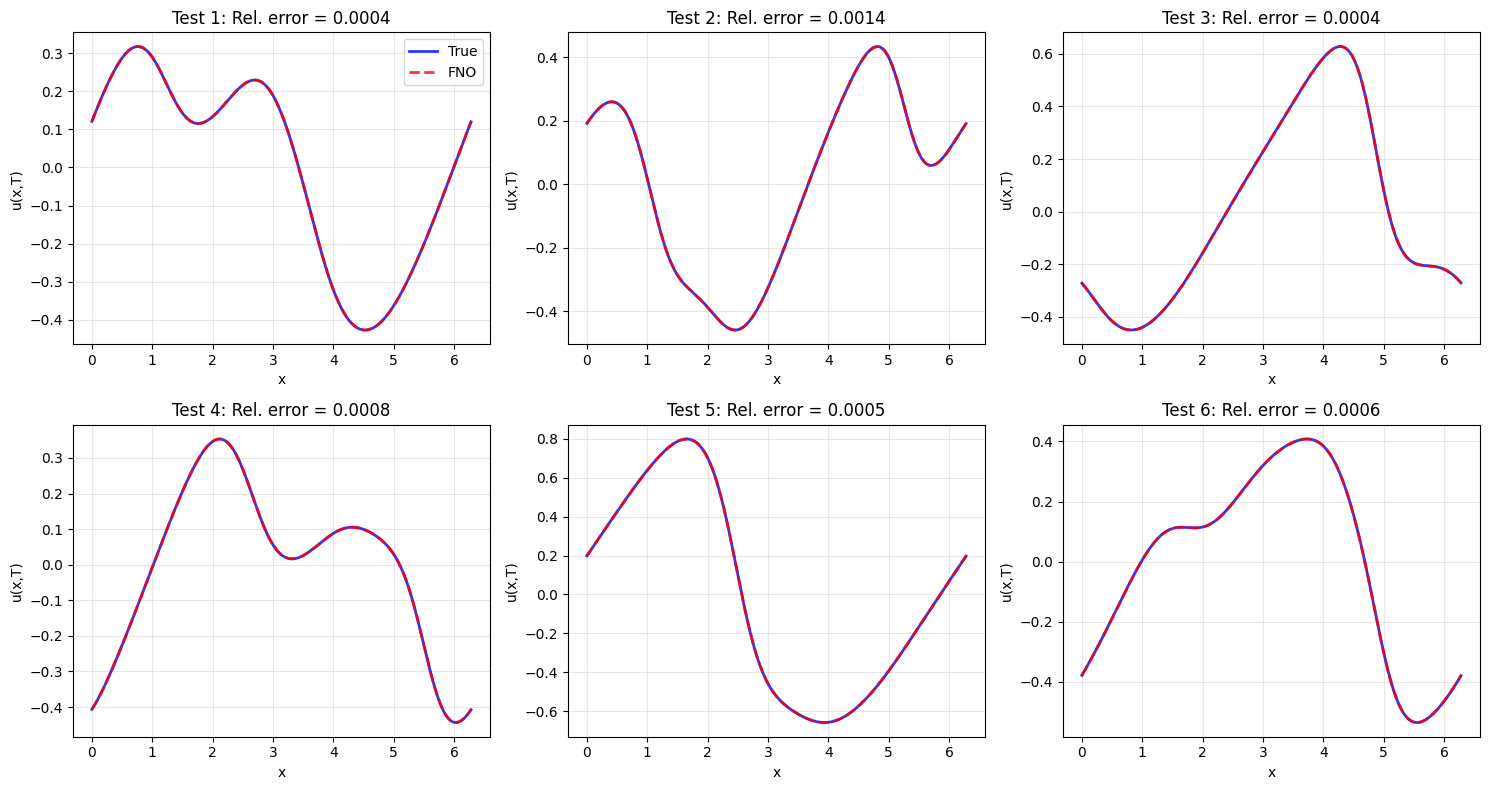

In [20]:
# Evaluate on test set
model_1d.eval()

with torch.no_grad():
    # Get predictions for first 6 test samples
    x_plot = x_test[:6].to(device)
    y_plot = y_test[:6]
    pred_plot = model_1d(x_plot).cpu()

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
x_grid = np.linspace(0, 2*np.pi, s)

for i in range(6):
    ax = axes[i//3, i%3]
    ax.plot(x_grid, y_plot[i], 'b-', linewidth=2, label='True', alpha=0.8)
    ax.plot(x_grid, pred_plot[i], 'r--', linewidth=2, label='FNO', alpha=0.8)

    error = torch.norm(pred_plot[i] - y_plot[i]) / torch.norm(y_plot[i])
    ax.set_title(f'Test {i+1}: Rel. error = {error:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,T)')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## 2D Example: Darcy Flow

### Problem Formulation

The 2D Darcy flow equation models steady-state flow in porous media:

$$-\nabla \cdot (a(x, y) \nabla u(x, y)) = f(x, y), \quad (x, y) \in [0, 1]^2$$

with zero boundary conditions: $u|_{\partial\Omega} = 0$.

**Operator learning task:** Learn the mapping

$$\mathcal{G}: a(x, y) \mapsto u(x, y)$$

from permeability coefficient $a$ to pressure/hydraulic head $u$.

**Physical interpretation:**
- $a(x, y)$: permeability field (how easily fluid flows)
- $u(x, y)$: pressure field
- $f(x, y)$: source term (set to 1 in our examples)

**Dataset:** 1024 samples with random piecewise constant permeability fields.

In [22]:
# Load Darcy flow data
print("Loading Darcy flow dataset...")

TRAIN_PATH = 'fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth1.mat'
TEST_PATH = 'fourier_neural_operator/Darcy_241/piececonst_r241_N1024_smooth2.mat'

# Load training data
reader = MatReader(TRAIN_PATH)
x_train_2d = reader.read_field('coeff')  # Permeability
y_train_2d = reader.read_field('sol')    # Solution

# Load test data
reader.load_file(TEST_PATH)
x_test_2d = reader.read_field('coeff')
y_test_2d = reader.read_field('sol')

print(f"Training data shape: {x_train_2d.shape}")
print(f"Test data shape: {x_test_2d.shape}")

# Subsample for computational efficiency
r = 3
s_2d = int(((241 - 1) / r) + 1)
x_train_2d = x_train_2d[:1000, ::r, ::r][:, :s_2d, :s_2d]
y_train_2d = y_train_2d[:1000, ::r, ::r][:, :s_2d, :s_2d]
x_test_2d = x_test_2d[:100, ::r, ::r][:, :s_2d, :s_2d]
y_test_2d = y_test_2d[:100, ::r, ::r][:, :s_2d, :s_2d]

print(f"Subsampled resolution: {s_2d} × {s_2d}")
print(f"Training samples: {x_train_2d.shape[0]}")
print(f"Test samples: {x_test_2d.shape[0]}")

Loading Darcy flow dataset...
Training data shape: torch.Size([1024, 241, 241])
Test data shape: torch.Size([1024, 241, 241])
Subsampled resolution: 81 × 81
Training samples: 1000
Test samples: 100


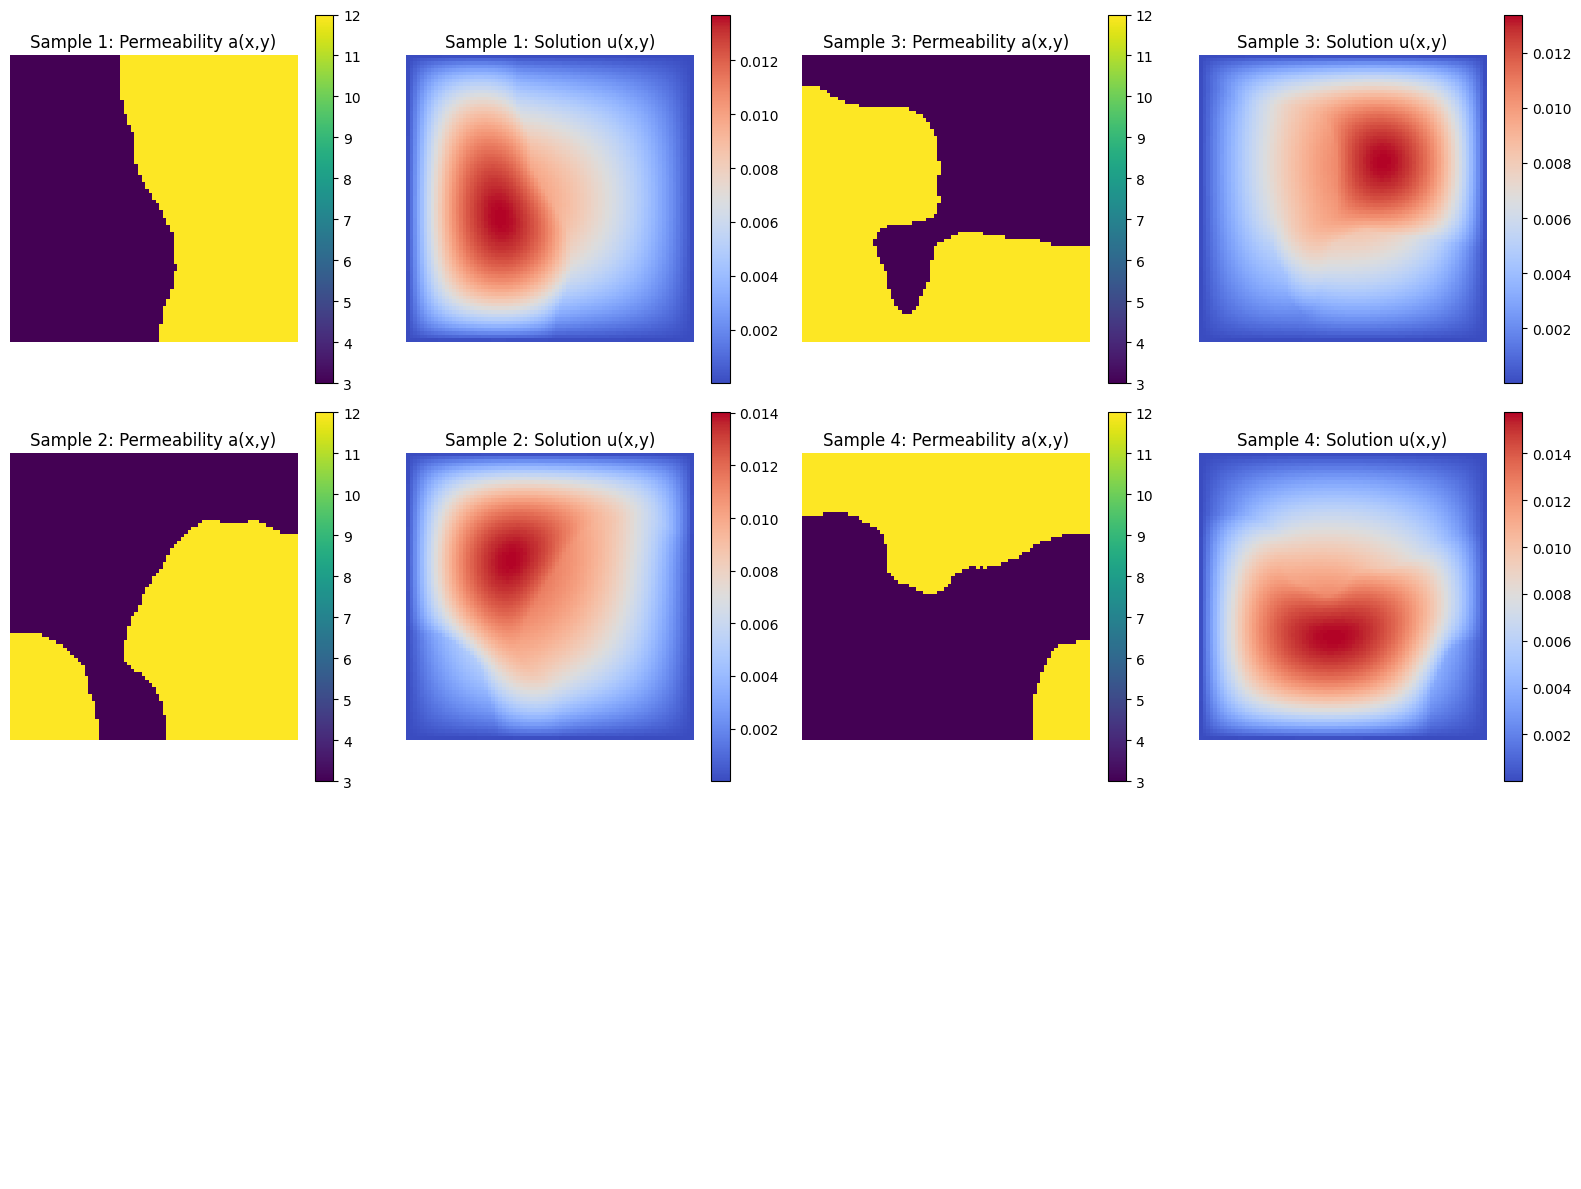

Observation: Lower permeability (darker regions) → higher pressure gradients


In [23]:
# Visualize samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(2):
    # Permeability
    im1 = axes[i, 0].imshow(x_train_2d[i], cmap='viridis')
    axes[i, 0].set_title(f'Sample {i+1}: Permeability a(x,y)')
    axes[i, 0].axis('off')
    plt.colorbar(im1, ax=axes[i, 0])

    # Solution
    im2 = axes[i, 1].imshow(y_train_2d[i], cmap='coolwarm')
    axes[i, 1].set_title(f'Sample {i+1}: Solution u(x,y)')
    axes[i, 1].axis('off')
    plt.colorbar(im2, ax=axes[i, 1])

    # Permeability (second pair)
    im3 = axes[i, 2].imshow(x_train_2d[i+2], cmap='viridis')
    axes[i, 2].set_title(f'Sample {i+3}: Permeability a(x,y)')
    axes[i, 2].axis('off')
    plt.colorbar(im3, ax=axes[i, 2])

    # Solution (second pair)
    im4 = axes[i, 3].imshow(y_train_2d[i+2], cmap='coolwarm')
    axes[i, 3].set_title(f'Sample {i+3}: Solution u(x,y)')
    axes[i, 3].axis('off')
    plt.colorbar(im4, ax=axes[i, 3])

# Hide unused subplot
for j in range(4):
    axes[2, j].axis('off')

plt.tight_layout()
plt.show()

print("Observation: Lower permeability (darker regions) → higher pressure gradients")

### 2D Fourier Neural Operator Implementation

In [24]:
class SpectralConv2d(nn.Module):
    """2D Fourier layer: FFT2 → Linear transform → IFFT2"""

    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes in x
        self.modes2 = modes2  # Number of Fourier modes in y

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)
        )

    def forward(self, x):
        # x: [batch, in_channels, height, width]
        batchsize = x.shape[0]

        # 2D FFT
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                            dtype=torch.cfloat, device=x.device)

        # Lower frequencies
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, :self.modes1, :self.modes2],
            self.weights1
        )

        # Higher frequencies (due to symmetry of real FFT)
        out_ft[:, :, -self.modes1:, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy",
            x_ft[:, :, -self.modes1:, :self.modes2],
            self.weights2
        )

        # 2D IFFT
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    """2D Fourier Neural Operator"""

    def __init__(self, modes1, modes2, width, n_layers=4):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers

        # Lifting
        self.fc0 = nn.Linear(3, width)  # input: (a(x,y), x, y)

        # Fourier layers
        self.fourier_layers = nn.ModuleList([
            SpectralConv2d(width, width, modes1, modes2) for _ in range(n_layers)
        ])

        # Skip connections
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(width, width, 1) for _ in range(n_layers)
        ])

        # Projection
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: [batch, height, width, 3]
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        # Lift
        x = self.fc0(x)  # [batch, height, width, width_channels]
        x = x.permute(0, 3, 1, 2)  # [batch, width_channels, height, width]

        # Fourier layers with skip connections
        for fourier, conv in zip(self.fourier_layers[:-1], self.conv_layers[:-1]):
            x1 = fourier(x)
            x2 = conv(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
            x = F.gelu(x1 + x2)

        # Last layer (no activation)
        x1 = self.fourier_layers[-1](x)
        x2 = self.conv_layers[-1](x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2

        # Project
        x = x.permute(0, 2, 3, 1)  # [batch, height, width, width_channels]
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # [batch, height, width, 1]

        return x.squeeze(-1)


# Initialize model
modes_2d = 12
width_2d = 32
model_2d = FNO2d(modes_2d, modes_2d, width_2d).to(device)

print(f"FNO2d Architecture:")
print(f"- Fourier modes: {modes_2d} × {modes_2d}")
print(f"- Hidden width: {width_2d}")
print(f"- Total parameters: {count_params(model_2d):,}")
print(f"- Device: {device}")

FNO2d Architecture:
- Fourier modes: 12 × 12
- Hidden width: 32
- Total parameters: 1,188,353
- Device: cuda


### Training the 2D FNO

In [25]:
# Normalize data
x_normalizer = UnitGaussianNormalizer(x_train_2d)
x_train_2d = x_normalizer.encode(x_train_2d)
x_test_2d = x_normalizer.encode(x_test_2d)

y_normalizer = UnitGaussianNormalizer(y_train_2d)
y_train_2d = y_normalizer.encode(y_train_2d)

# Add spatial coordinates
grids = []
grids.append(np.linspace(0, 1, s_2d))
grids.append(np.linspace(0, 1, s_2d))
grid_2d = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid_2d = grid_2d.reshape(1, s_2d, s_2d, 2)
grid_2d = torch.tensor(grid_2d, dtype=torch.float32)

x_train_2d = torch.cat([
    x_train_2d.reshape(x_train_2d.shape[0], s_2d, s_2d, 1),
    grid_2d.repeat(x_train_2d.shape[0], 1, 1, 1)
], dim=3)

x_test_2d = torch.cat([
    x_test_2d.reshape(x_test_2d.shape[0], s_2d, s_2d, 1),
    grid_2d.repeat(x_test_2d.shape[0], 1, 1, 1)
], dim=3)

# Data loaders
batch_size_2d = 20
train_loader_2d = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_2d, y_train_2d),
    batch_size=batch_size_2d, shuffle=True
)
test_loader_2d = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_2d, y_test_2d),
    batch_size=batch_size_2d, shuffle=False
)

print(f"Data prepared for training")
print(f"Input shape: {x_train_2d.shape}")
print(f"Output shape: {y_train_2d.shape}")

Data prepared for training
Input shape: torch.Size([1000, 81, 81, 3])
Output shape: torch.Size([1000, 81, 81])


In [27]:
# Training configuration
epochs_2d = 200  # Reduced from 500 for faster demonstration
learning_rate_2d = 0.001

optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=learning_rate_2d, weight_decay=1e-4)
scheduler_2d = torch.optim.lr_scheduler.StepLR(optimizer_2d, step_size=50, gamma=0.5)

myloss_2d = LpLoss(d=2, p=2, size_average=False)

# Move normalizer to device
if device.type == 'cuda':
    y_normalizer.cuda()
elif device.type == 'cpu':
    y_normalizer.cpu()

# Training loop
train_losses_2d = []
test_losses_2d = []

print(f"Training FNO2d for {epochs_2d} epochs...")
pbar = tqdm(range(epochs_2d), desc="Training")

for epoch in pbar:
    model_2d.train()
    train_l2 = 0

    for x, y in train_loader_2d:
        x, y = x.to(device), y.to(device)

        optimizer_2d.zero_grad()
        out = model_2d(x).reshape(batch_size_2d, s_2d, s_2d)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss_2d(out.view(batch_size_2d, -1), y.view(batch_size_2d, -1))
        loss.backward()

        optimizer_2d.step()
        train_l2 += loss.item()

    scheduler_2d.step()

    # Evaluation
    model_2d.eval()
    test_l2 = 0
    with torch.no_grad():
        for x, y in test_loader_2d:
            x, y = x.to(device), y.to(device)
            out = model_2d(x).reshape(batch_size_2d, s_2d, s_2d)
            out = y_normalizer.decode(out)
            test_l2 += myloss_2d(out.view(batch_size_2d, -1), y.view(batch_size_2d, -1)).item()

    train_l2 /= len(x_train_2d)
    test_l2 /= len(x_test_2d)

    train_losses_2d.append(train_l2)
    test_losses_2d.append(test_l2)

    if epoch % 20 == 0:
        pbar.set_postfix({'Train L2': f'{train_l2:.6f}', 'Test L2': f'{test_l2:.6f}'})

print(f"Final train loss: {train_losses_2d[-1]:.6f}")
print(f"Final test loss: {test_losses_2d[-1]:.6f}")

Training FNO2d for 200 epochs...


Training: 100%|██████████| 200/200 [06:23<00:00,  1.92s/it, Train L2=0.003189, Test L2=0.005683]

Final train loss: 0.003086
Final test loss: 0.005551


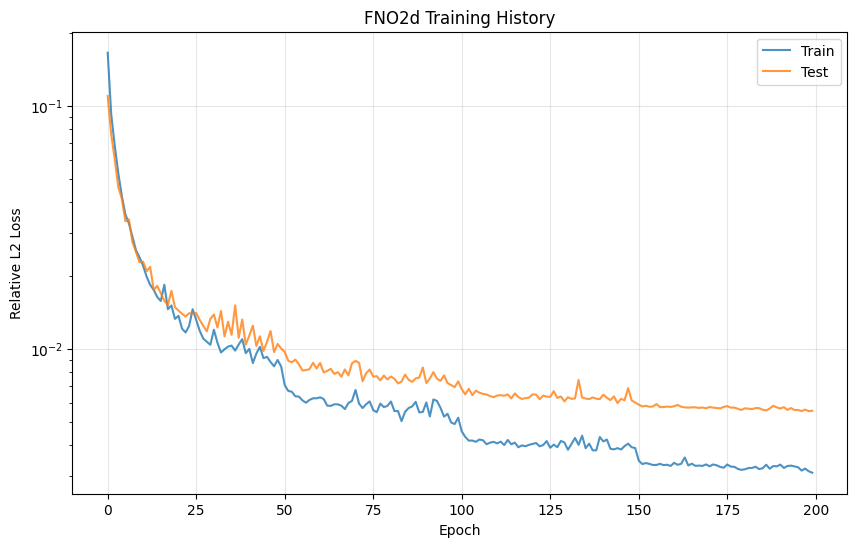

In [28]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2d, label='Train', alpha=0.8)
plt.plot(test_losses_2d, label='Test', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Relative L2 Loss')
plt.title('FNO2d Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

### 2D FNO Results

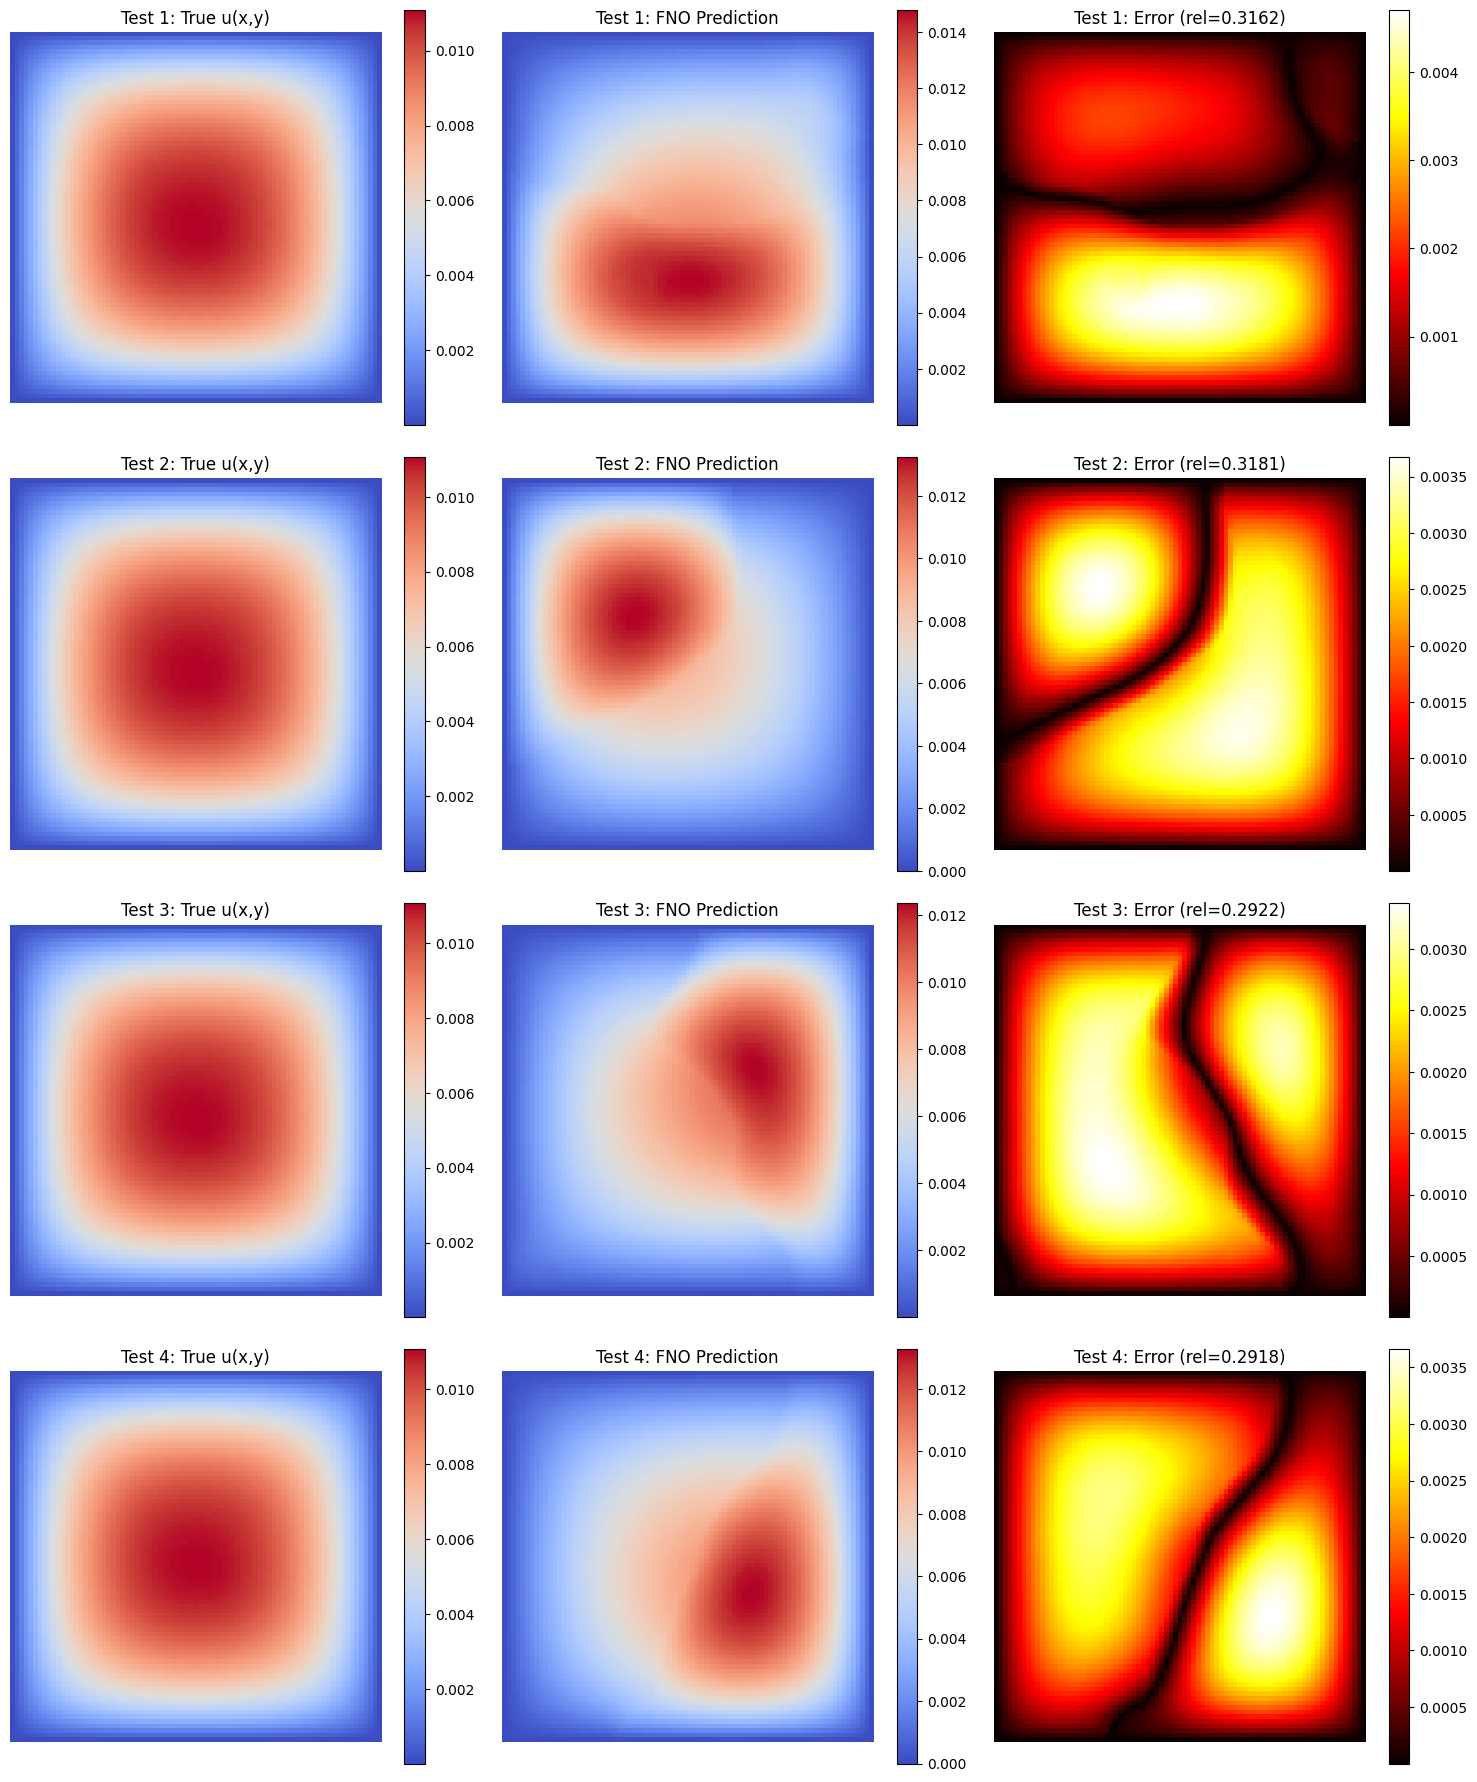

In [29]:
# Evaluate on test set
model_2d.eval()

with torch.no_grad():
    # Get predictions for first 4 test samples
    x_plot_2d = x_test_2d[:4].to(device)
    y_plot_2d = y_test_2d[:4].to(device)
    pred_plot_2d = model_2d(x_plot_2d)

    # Decode
    pred_plot_2d = y_normalizer.decode(pred_plot_2d).cpu()
    y_plot_2d = y_normalizer.decode(y_plot_2d).cpu()

# Visualize
fig, axes = plt.subplots(4, 3, figsize=(15, 18))

for i in range(4):
    # True solution
    im1 = axes[i, 0].imshow(y_plot_2d[i], cmap='coolwarm')
    axes[i, 0].set_title(f'Test {i+1}: True u(x,y)')
    axes[i, 0].axis('off')
    plt.colorbar(im1, ax=axes[i, 0])

    # Prediction
    im2 = axes[i, 1].imshow(pred_plot_2d[i], cmap='coolwarm')
    axes[i, 1].set_title(f'Test {i+1}: FNO Prediction')
    axes[i, 1].axis('off')
    plt.colorbar(im2, ax=axes[i, 1])

    # Error
    error_map = torch.abs(y_plot_2d[i] - pred_plot_2d[i])
    rel_error = torch.norm(pred_plot_2d[i] - y_plot_2d[i]) / torch.norm(y_plot_2d[i])
    im3 = axes[i, 2].imshow(error_map, cmap='hot')
    axes[i, 2].set_title(f'Test {i+1}: Error (rel={rel_error:.4f})')
    axes[i, 2].axis('off')
    plt.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()
plt.show()

## Key Insights & Analysis

### What Makes FNO Special?

1. **Mesh Independence**
   - Train on one resolution, evaluate on any resolution
   - Works because we learn in Fourier space (continuous representation)
   - Discretization is only for FFT computation

2. **Computational Efficiency**
   - FFT: $O(N \log N)$ vs dense convolution $O(N^2)$
   - Once trained: milliseconds per evaluation
   - Traditional solver: seconds to minutes

3. **Global Receptive Field**
   - Fourier modes capture global information
   - No need to stack many layers for long-range dependencies
   - Contrast with CNNs: local receptive fields

4. **Physics-Informed Design**
   - Leverages 50+ years of spectral methods knowledge
   - Natural for PDEs with periodic boundary conditions
   - Low-frequency truncation = implicit regularization

### Limitations

1. **Periodic Boundary Conditions**
   - Standard FFT assumes periodicity
   - Extensions needed for general geometries (Geo-FNO)

2. **Data Requirements**
   - Need many solved PDE instances for training
   - Expensive data generation phase

3. **Black Box Nature**
   - No explicit PDE enforcement during training
   - May violate physical constraints

### FNO vs DeepONet

| Aspect | DeepONet | FNO |
|--------|----------|-----|
| **Architecture** | Branch-Trunk | Spectral Convolution |
| **Space** | Physical | Fourier |
| **Queries** | Arbitrary points | Grid points (FFT) |
| **Best for** | Irregular domains | Periodic domains |
| **Parameters** | More | Fewer |
| **Speed** | Fast | Faster (FFT) |

## Summary

### What We Learned

1. **Conceptual Foundation**
   - CNNs are local kernel operators
   - FNO extends to global kernel operators in Fourier space
   - Physics naturally lives in spectral domain

2. **Mathematical Framework**
   - Fourier Transform decomposes functions into frequency components
   - Convolution theorem: multiplication in Fourier space
   - Operator parametrization: $\mathcal{K}(v) = \mathcal{F}^{-1}(R_\phi \cdot \mathcal{F}(v))$

3. **Architecture**
   - Spectral convolution layers: FFT → Learn → IFFT
   - Skip connections for expressivity
   - Mode truncation for efficiency and regularization

4. **Applications**
   - 1D Burgers: temporal evolution of shock waves
   - 2D Darcy: steady-state flow in porous media
   - Mesh-independent predictions

### When to Use FNO

**Ideal scenarios:**
- Periodic or translation-invariant problems
- Need for resolution independence
- Real-time PDE solving
- Large-scale parameter sweeps

**Consider alternatives when:**
- Complex, non-periodic geometries
- Sparse, irregular data
- Need point-wise queries at arbitrary locations
- Limited training data

### Extensions

- **Geo-FNO:** Arbitrary geometries with coordinate transforms
- **Physics-Informed FNO:** Add PDE residual to loss
- **Factorized FNO:** Low-rank approximations for 3D
- **U-FNO:** U-Net architecture with Fourier layers

---

**Further Reading:**
- [Original FNO Paper](https://arxiv.org/abs/2010.08895)
- [Geo-FNO](https://arxiv.org/abs/2207.05209)
- [Physics-Informed Neural Operators](https://arxiv.org/abs/2111.03794)
- [Neural Operator Review](https://arxiv.org/abs/2108.08481)